In [1]:
from __future__ import division
import os
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from elephant.spike_train_generation import homogeneous_poisson_process
from quantities import Hz, s, ms
from util import *
pd = params_dict

np.random.seed(1234)
%matplotlib inline

print(params_dict)

{'day_seconds': 1500, 'days': 5, 'density': 0.25, 'dend_L': 70, 'event_range': [1, 2], 'event_min': 0.014285714285714285, 'event_max': 0.02857142857142857, 'event_mean': 0.02142857142857143, 'event_sd': 0.0023809523809523807, 'mito_pop': 500, 'MM_pct_init': 1, 'recov_means': array([  60,  120,  180,  240,  300,  360,  420,  480,  540,  600,  900,
       1200, 1500]), 'recov_sd': 150.0, 'event_hz': [0.001, 0.012, 0.035, 0.058, 0.081, 0.104, 0.127, 0.15, 0.25, 0.35, 0.5]}


In [2]:
#dose_response = np.load('condition_1/doseresponse.npy').item()

dose_response = {}

num_runs  = 10

sns.set_palette("Spectral",num_runs) # Set color palette for plots
color_list = [tuple((np.array(x)+0.85)%1) for x in sns.color_palette("Spectral", num_runs)]

# Simulation Parameters

In [3]:
### Create Spike trains from poisson process
spiketrain_list = []
plot_rasters = []

event_hz = [pd['event_hz'][3]]

for i in range(num_runs):
    day_holder = []
    for j in range(len(event_hz)):
        day = homogeneous_poisson_process(rate=event_hz[j]*Hz,
                                               t_start=(j*pd['day_seconds'])*s+0.01*s,
                                               t_stop=(j+1)*pd['day_seconds']*s, as_array=True)
        day_holder = np.concatenate([day, day_holder])
    
    spiketrain_list.append(day_holder)
    


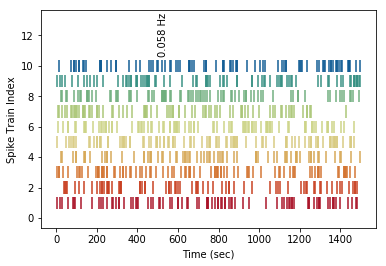

In [4]:
### Spike Raster Plot 
extra_height = 3
plt.figure()
plt.plot(np.zeros(day_seconds), 'o', markersize=0)
for i, spiketrain in enumerate(spiketrain_list):
    t = spiketrain
    plt.vlines(t, i+0.6, i+1.4, color = color_list[i])

plt.plot((num_runs+extra_height)*np.ones(day_seconds), 'o', markersize=0)
for i in range(len(event_hz)-1):
    plt.axvline(x=(i+1)*day_seconds, color='k', alpha=0.2)

for i in range(len(event_hz)):
    x = ((i)*day_seconds + day_seconds/3)
    y = num_runs + extra_height
    plt.annotate('{0:0.3f} Hz'.format(event_hz[i]),(x,y), rotation = 90)
#plt.axis('tight')
#plt.xlim([0,10])
plt.xlabel('Time (sec)')
plt.ylabel('Spike Train Index')
plt.gca().tick_params(axis='both', which='major', labelsize=10)
#plt.suptitle('Spike Raster Plot', fontsize=12)
plt.savefig('SpikeRaster.png', format='png')
plt.savefig('SpikeRaster.svg', format='svg')
plt.show()
plt.close()

In [77]:
#### RUN  SINGLE SIMULATION
recovery_times = np.zeros(num_runs)
track_pct_mm = []
print( "Started series of {} runs".format(num_runs))
for i in range(num_runs):
    recovery_time=0
    pct_mm = []
    synaptic_event_times = spiketrain_list[i]
    
    mito_list = populate_list_n(pd['mito_pop'], pd['MM_pct_init'], pd['recov_means'][0], pd['recov_sd'])
    
    for j in range(len(event_hz)*pd['day_seconds']):
        if j in [int(np.round(x)) for x in synaptic_event_times]:
            #generate percentage affected by syn event
            frac_immobilized = 0.1# np.random.normal(loc=pd['event_mean'], scale=pd['event_sd'])
            #select mitochondria to immobilize
            immobilized_ind = np.random.choice(pd['mito_pop'], int(np.round(pd['mito_pop']*frac_immobilized)))
            for k in immobilized_ind:
                mito_list[k].freeze(j)
    
        for k in range(pd['mito_pop']):
            mito_list[k].release(j)
        # track fraction of mitochondria that are mobile
        mobile_frac = calc_frac_mm(mito_list)  
        pct_mm.append(mobile_frac)
        if event_hz[int(j/pd['day_seconds'])] == 0:
            rec_recov = True
            if rec_recov:
                recovery_time +=1
            if mobile_frac == pct_mm[0]:
                recovery_times[i]=recovery_time
                rec_recov = False
    
    track_pct_mm.append(pct_mm)
    if i == 0:
        print( "Finished "),
    print ("{}...".format(i+1)),
print( "Done")

Started series of 10 runs
Finished 
1...
2...
3...
4...
5...
6...
7...
8...
9...
10...
Done


10


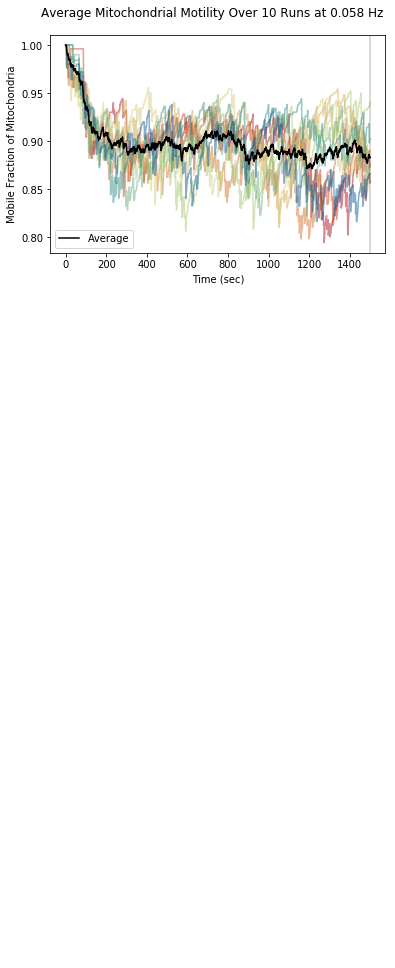

In [78]:
average_pct_mm = []
print(len(track_pct_mm))
for i in range(len(track_pct_mm[0])):
    avg_sum = 0
    for j in range(num_runs):
        avg_sum += track_pct_mm[j][i]
    avg = avg_sum/num_runs
    average_pct_mm.append(avg)

plt.figure()
for i in range(num_runs):
    plt.plot(track_pct_mm[i], color=color_list[i],alpha = 0.5)
plt.plot(average_pct_mm, 'k', label = 'Average')
for i in range(len(event_hz)):
    plt.axvline(x=(i+1)*day_seconds, color='k', alpha=0.2)
plt.legend(loc=0)
for i in range(len(event_hz)):
    x = ((i)*day_seconds + day_seconds/2)
    y = 0.08
    plt.annotate('{0:.3f}Hz'.format(event_hz[i]),(x,y), rotation=90)
#plt.ylim([0,0.1])
#plt.xlim([0,days*day_seconds+10])
plt.ylabel('Mobile Fraction of Mitochondria')
plt.xlabel('Time (sec)')
plt.suptitle('Average Mitochondrial Motility Over {} Runs at {} Hz'.format(num_runs, event_hz[0]), fontsize = 12)
plt.savefig('AvgMitoMotility{}.png'.format(event_hz[0]), format='png')
plt.show()
plt.close()

### For Current Mean, track changes from initial mobile mito pop

In [ ]:
## error raised -- sorted keys not yet defined... move this block
plt.figure()
for i in range(len(sorted_keys)):
    if sorted_pct_imm[i]-MM_pct_init> 0:
        col_flag = color_list[0]
    else:
        col_flag = color_list[-1]
    plt.bar(i+0.5, sorted_pct_imm[i]-MM_pct_init, width=0.5, color=col_flag)
plt.ylim([-0.2, 1])
plt.xticks(np.arange(len(sorted_keys))+0.5, sorted_keys)
plt.yticks((np.arange(7)-1)*0.2, (np.arange(7)-1)*20)
plt.xlabel('Stimulation Frequency (Hz)')
plt.ylabel('$\Delta$ Motile Mitos (%)')
plt.savefig(savedir+'delta_mitos.svg', format='svg')
plt.show()

In [ ]:
#event_hz = np.round(event_hzs+[0],3)
event_hzs = [0.001, 0.012, 0.035, 0.058, 0.081, 0.104, 0.127, 0.15, 0.25, 0.35, 0.5]
event_hz = [0.035]
print event_hz

In [ ]:
# make example histogram of recovery times
mito_list = populate_list_n(mito_pop, MM_pct_init, mean_stop, sd_stop)
recov_times = []
for i in range(mito_pop):
    recov_times.append(mito_list[i].MM_stop)

quick_mitos = [x for x in recov_times if x<10]
print(len(quick_mitos)/len(mito_list))

plt.hist(recov_times, bins=25, color = color_list[0])
#plt.xlim([0, days*day_seconds])
plt.ylabel('Number of Mitochondria')
plt.xlabel('Recovery Time (sec)')
#plt.suptitle('Distribution of Mitochondria \nRecovery Times (sec)')
plt.savefig('Mito recovery time distribution.png', format='png')
plt.savefig('Mito recovery time distribution.svg', format='svg')
plt.show()
plt.close()

In [ ]:
pct_imm = []
key_imm = []
for i in dose_response.keys():
    key_imm.append(float(i))
    pct_imm.append(dose_response[i])
    
    print(key_imm[-1], pct_imm[-1])


sorted_pct_imm = []
sorted_keys = []

for i in range(len(pct_imm)):
    sorted_keys.append(key_imm[np.argsort(key_imm)[i]])
    sorted_pct_imm.append(pct_imm[np.argsort(key_imm)[i]])
print(sorted_keys)
plt.figure()
plt.plot(sorted_keys, sorted_pct_imm, 'o-')
#plt.ylim([0, 0.06])

plt.xlabel('Stimulation Frequency (Hz)')
plt.ylabel('Mobile Mitochondria (%)')
plt.savefig('doseresponse.svg', format='svg')
plt.savefig('doseresponse.png', format='png')
plt.show()
plt.close()

In [ ]:
print(recovery_times)
if len(recovery_times[recovery_times>0]) != 0:
    avg_recov = int(np.mean(recovery_times[recovery_times>0]))
else: 
    avg_recov= 'NaN'
r_flag = True
        
        
plt.figure()
for i in range(num_runs):
    plt.plot(track_pct_mm[i], alpha = 0.2)
plt.plot(average_pct_mm, 'k', label = 'Average')
for i in range(len(event_hz)):
    plt.axvline(x=(i+1)*day_seconds, color='k', alpha=0.2)
    if event_hz[i] == 0 and r_flag:
        plt.axvline(x=(i)*day_seconds, color='r', alpha=0.7)
        r_time = (i)*day_seconds +10 
        plt.annotate('Recovery \nin {} sec'.format(avg_recov), (r_time,1.05*average_pct_mm[0]), color='r')
        r_flag = False
        
plt.legend(loc=0)
for i in range(len(event_hz)):
    x = ((i)*day_seconds + day_seconds/3)
    y = 0.09
    plt.annotate('{0:0.3f} Hz'.format(event_hz[i]),(x,y), rotation = 90)
    
#plt.ylim([0,0.1])
plt.ylabel('Mobile Fraction of Mitochondria')
plt.xlabel('Time (sec)')
plt.suptitle('Average Mitochondrial Motility Over {} Runs'.format(num_runs), fontsize = 12)
plt.savefig('Recovery.png', format='png')
plt.show()
plt.close()

# Full Simulation Run for Dose Responses

In [ ]:
#### Run full event hz for dictionary population

recov_means = np.array([1,2,3,4,5,6,7,8,9,10,15,20,25])*60
for mean_stop in recov_means:
    mean_stop_min = int(mean_stop/60)
    print("Mean Stop ", mean_stop_min)
    if not os.path.isdir('condition_{}'.format(mean_stop_min)):
        os.makedirs('condition_{}'.format(mean_stop_min))
    savedir = 'condition_{}/'.format(mean_stop_min)
    
    event_hzs = [0.001, 0.012, 0.035, 0.058, 0.081, 0.104, 0.127, 0.15, 0.25, 0.35, 0.5]
    for ev_hz in event_hzs:
        event_hz = [ev_hz]

        ### Create Spike trains from poisson process
        spiketrain_list = []
        plot_rasters = []

        for i in range(num_runs):
            for j in range(len(event_hz)):
                day = homogeneous_poisson_process(rate=event_hz[j]*Hz,
                                                       t_start=0.1*s,
                                                       t_stop=day_seconds*s, as_array=True)
                c1 = np.concatenate([[0],day])
                plot_rasters.append(np.concatenate([c1, [day_seconds-1]]))
                if event_hz[j] == 0:
                    day= np.concatenate([day,[3*day_seconds - 1]])
                a = day+(j*day_seconds)
                if j == 0: 
                    day_holder = np.concatenate([[0,1],a])
                else:
                    day_holder = np.concatenate([day_holder,a])

            spiketrain_list.append(day_holder)

        ### Spike Raster Plot
        if mean_stop == recov_means[0]:
            extra_height = 2
            plt.figure()
            plt.plot(np.zeros(day_seconds), 'o', markersize=0)
            for i, spiketrain in enumerate(spiketrain_list):
                #if i == 0: 
                #    plt.plot((i)*np.ones(len(event_hz)*day_seconds), 'o', markersize=0)
                t = spiketrain #.rescale(s)
                plt.plot(t, (i+1)* np.ones_like(t), marker='o', markersize=10, color = color_list[i])
                #if i == len(spiketrain_list)-1:
                #    plt.plot((len(spiketrain_list)+1)*np.ones(len(event_hz)*day_seconds), 'o', markersize=0)

            plt.plot((num_runs+extra_height)*np.ones(day_seconds), 'o', markersize=0)
            for i in range(len(event_hz)-1):
                plt.axvline(x=(i+1)*day_seconds, color='k', alpha=0.2)

            for i in range(len(event_hz)):
                x = ((i)*day_seconds + day_seconds/3)
                y = num_runs + extra_height
                plt.annotate('{0:0.3f} Hz'.format(event_hz[i]),(x,y), rotation = 90)
            plt.axis('tight')
            #plt.xlim([0,10])
            plt.xlabel('Time (sec)')
            plt.ylabel('Spike Train Index')
            plt.gca().tick_params(axis='both', which='major', labelsize=10)
            #plt.suptitle('Spike Raster Plot', fontsize=12)
            plt.savefig('SpikeRaster{}.png'.format(event_hz[0]), format='png')
            plt.savefig('SpikeRaster{}.svg'.format(event_hz[0]), format='svg')
            #plt.show()
            plt.close()

        mito_list = populate_list_n(mito_pop, MM_pct_init, mean_stop, sd_stop)

        #### RUN SIMULATION
        recovery_times = np.zeros(num_runs)
        track_pct_mm = []
        print( "{} runs @{} Hz".format(num_runs, event_hz[0]))
        for i in range(num_runs):
            recovery_time=0
            pct_mm = []
            synaptic_event_times = spiketrain_list[i]
            #normally distributed stopping times
            mito_list = populate_list_n(mito_pop, MM_pct_init, mean_stop, sd_stop)
            #bimodally distributed stopping times
            #mito_list = populate_list_bimodal(mito_pop, MM_pct_init, fast_stop, slow_stop)
            for j in range(len(event_hz)*day_seconds):
                if j in [int(np.round(x)) for x in synaptic_event_times]:
                    #generate percentage affected by syn event
                    frac_immobilized = np.random.normal(loc=pd['event_mean'], scale=pd['event_sd'])
                    #select mitochondria to immobilize
                    immobilized_ind = np.random.choice(mito_pop, int(np.round(mito_pop*frac_immobilized)))
                    for k in immobilized_ind:
                        mito_list[k].freeze(j)

                for k in range(mito_pop):
                    mito_list[k].release(j)
                # track fraction of mitochondria that are mobile
                mobile_frac = calc_frac_mm(mito_list)  
                pct_mm.append(mobile_frac)
                if event_hz[int(j/day_seconds)] == 0:
                    rec_recov = True
                    if rec_recov:
                        recovery_time +=1
                    if mobile_frac == pct_mm[0]:
                        recovery_times[i]=recovery_time
                        rec_recov = False

            track_pct_mm.append(pct_mm)
            if i == 0:
                print ("Finished "),
            print( "{}...".format(i+1)),
        print( "Done")

        average_pct_mm = []
        for i in range(len(track_pct_mm[0])):
            avg_sum = 0
            for j in range(num_runs):
                avg_sum += track_pct_mm[j][i]
            avg = avg_sum/num_runs
            average_pct_mm.append(avg)

        dose_response['{}'.format(event_hz[0])] = running_mean(average_pct_mm, 25)[-1]
        np.save(savedir+'doseresponse.npy',dose_response)
        
        plt.figure()
        for i in range(num_runs):
            plt.plot(track_pct_mm[i], alpha = 0.5)
        plt.plot(average_pct_mm, 'k', label = 'Average')
        for i in range(len(event_hz)):
            plt.axvline(x=(i+1)*day_seconds, color='k', alpha=0.2)
        plt.legend(loc=0)
        for i in range(len(event_hz)):
            x = ((i)*day_seconds + day_seconds/2)
            y = 0.08
            plt.annotate('{0:.3f}Hz'.format(event_hz[i]),(x,y), rotation=90)
        #plt.ylim([0,0.1])
        #plt.xlim([0,days*day_seconds+10])
        plt.ylabel('Mobile Fraction of Mitochondria')
        plt.xlabel('Time (sec)')
        plt.suptitle('Average Mitochondrial Motility Over {} Runs'.format(num_runs), fontsize = 12)
        plt.savefig(savedir+'AvgMitoMotility{}.png'.format(event_hz[0]), format='png')
        #plt.show()
        plt.close()

In [ ]:
# make example histogram of recovery times
mean_times = [1,2,3,4,5,6,7,8,9,10,15,20,25]
for mean_s in mean_times:
    mean_stop = mean_s*60
    mito_list = populate_list_n(mito_pop, MM_pct_init, mean_stop, sd_stop)
    
    recov_times = []
    for i in range(mito_pop):
        recov_times.append(mito_list[i].MM_stop)

    quick_mitos = [x for x in recov_times if x<10]
    print( len(quick_mitos)/len(mito_list))

    plt.hist(recov_times, bins=25, color = 'k')
    plt.xlim([0, 2000])
    plt.ylim([0,200])
    plt.ylabel('Number of Mitochondria')
    plt.xlabel('Recovery Time (sec)')
    #plt.suptitle('Distribution of Mitochondria \nRecovery Times (sec)')
    #plt.savefig('data/MeanRecovTimes/condition_{}/recov_distribution.png'.format(mean_s), format='png')
    #plt.savefig('data/MeanRecovTimes/condition_{}/recov_distribution.svg'.format(mean_s), format='svg')
    plt.show()
    plt.close()

### Junkyard / Extra Stuff

In [ ]:
extra_height = 2
plt.figure()
plt.plot(np.zeros(day_seconds), 'o', markersize=0)
for i, spiketrain in enumerate(plot_rasters, -1):
    #print spiketrain
    if i == 0: 
        plt.plot((i)*np.ones(day_seconds), 'o', markersize=0)
    t = spiketrain #.rescale(s)
    plt.plot(t, (i+1)* np.ones_like(t), color = 'k', marker='|', markersize=10)
#    if i == len(spiketrain_list)-1:
#        plt.plot((len(spiketrain_list)+1)*np.ones(day_seconds), 'o', markersize=0)

plt.plot((num_runs+extra_height)*np.ones(day_seconds), 'o', markersize=0)

for i, entry in enumerate(event_hz):
    x = 525
    y = i-0.15
    plt.annotate('{0:0.3f} Hz'.format(entry),(x,y), rotation = 0)
plt.axis('tight')

plt.xlabel('Time (sec)')
plt.ylabel('Spike Train Index')
plt.gca().tick_params(axis='both', which='major', labelsize=10)
#plt.suptitle('Spike Raster Plot', fontsize=12)
plt.savefig('bwSpikeRaster.png', format='png')
plt.savefig('bwSpikeRaster.svg', format='svg')
plt.show()
plt.close()